# Realized Volatility Forecast

In [123]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor

## Exploratory Data Analysis

In [124]:
spyTicker = yf.Ticker("SPY") # SPDR S&P 500 ETF Trust
vixTicker = yf.Ticker("^VIX") # VIX
df_spy = spyTicker.history(period="max")
df_vix = vixTicker.history(period="max")

In [125]:
# Remove extra rows from vix to match spy
df_vix = df_vix.drop(df_vix.loc['1990':'1993-01-28'].index)

In [126]:
# Remove Timestamps to make rows line up better across datasets
df_spy.index = df_spy.index.date
df_vix.index = df_vix.index.date

In [127]:
df_spy

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
1993-01-29,24.330338,24.330338,24.209291,24.313046,1003200,0.0,0.0,0.0
1993-02-01,24.330323,24.485954,24.330323,24.485954,480500,0.0,0.0,0.0
1993-02-02,24.468663,24.555125,24.416786,24.537832,201300,0.0,0.0,0.0
1993-02-03,24.572424,24.814516,24.555131,24.797224,529400,0.0,0.0,0.0
1993-02-04,24.883693,24.952863,24.607016,24.900986,531500,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
2025-11-17,669.700012,673.710022,662.169983,665.669983,90456100,0.0,0.0,0.0
2025-11-18,662.099976,665.119995,655.859985,660.080017,114467500,0.0,0.0,0.0
2025-11-19,660.780029,667.340027,658.750000,662.630005,94703000,0.0,0.0,0.0
2025-11-20,672.909973,675.559998,651.890015,652.530029,165293500,0.0,0.0,0.0


In [128]:
df_vix

,Open,High,Low,Close,Volume,Dividends,Stock Splits
1993-01-29,12.490000,13.160000,12.420000,12.420000,0,0.0,0.0
1993-02-01,12.510000,12.920000,12.180000,12.330000,0,0.0,0.0
1993-02-02,12.470000,12.890000,12.220000,12.250000,0,0.0,0.0
1993-02-03,11.980000,12.340000,11.790000,12.120000,0,0.0,0.0
1993-02-04,11.860000,12.840000,11.690000,12.290000,0,0.0,0.0
...,...,...,...,...,...,...,...
2025-11-17,19.580000,23.440001,19.540001,22.379999,0,0.0,0.0
2025-11-18,23.540001,25.840000,22.910000,24.690001,0,0.0,0.0
2025-11-19,24.520000,24.790001,21.930000,23.660000,0,0.0,0.0
2025-11-20,20.780001,28.270000,19.280001,26.420000,0,0.0,0.0


In [129]:
# join datasets
dataset = pd.merge(df_spy, df_vix, left_index=True, right_index=True, suffixes=('_SPY','_VIX'))
dataset = dataset.drop(['Dividends_SPY','Stock Splits_SPY', 'Capital Gains', 'Dividends_VIX', 'Stock Splits_VIX', 'Volume_VIX'], axis=1)

# Load FFER data, make Column A the index
FFER = pd.read_csv("FFER.csv", index_col=0, parse_dates=True)

# Rename FFER column 
FFER.columns = ["FFER"]

# Merge on the index
dataset = dataset.join(FFER, how="left")

# Load US Economic Uncertainty data, make Column A the index
econ_uncert = pd.read_csv("FFER.csv", index_col=0, parse_dates=True)

# Rename US Econmic Unceratainty column 
econ_uncert.columns = ["Economic Uncertainty"]

# Merge on the index
dataset = dataset.join(econ_uncert, how="left")

print(dataset.head())
print(dataset.isna().sum())


             Open_SPY   High_SPY    Low_SPY  Close_SPY  Volume_SPY  Open_VIX  \
1993-01-29  24.330338  24.330338  24.209291  24.313046     1003200     12.49   
1993-02-01  24.330323  24.485954  24.330323  24.485954      480500     12.51   
1993-02-02  24.468663  24.555125  24.416786  24.537832      201300     12.47   
1993-02-03  24.572424  24.814516  24.555131  24.797224      529400     11.98   
1993-02-04  24.883693  24.952863  24.607016  24.900986      531500     11.86   

            High_VIX  Low_VIX  Close_VIX  FFER  Economic Uncertainty  
1993-01-29     13.16    12.42      12.42  3.02                  3.02  
1993-02-01     12.92    12.18      12.33  3.25                  3.25  
1993-02-02     12.89    12.22      12.25  3.18                  3.18  
1993-02-03     12.34    11.79      12.12  3.56                  3.56  
1993-02-04     12.84    11.69      12.29  3.08                  3.08  
Open_SPY                0
High_SPY                0
Low_SPY                 0
Close_SPY      

In [130]:
# Download 3M T-Bill yield
tbill = yf.Ticker("^IRX")
df_tbill = tbill.history(period="max")

# Align date index
df_tbill.index = df_tbill.index.date
df_tbill = df_tbill[['Close']] # Take yield

# Rename column
df_tbill.columns = ['TBill_3M']

# Merge with your main dataset
dataset = dataset.join(df_tbill, how="left")

In [131]:
dataset

,Open_SPY,High_SPY,Low_SPY,Close_SPY,Volume_SPY,Open_VIX,High_VIX,Low_VIX,Close_VIX,FFER,Economic Uncertainty,TBill_3M
1993-01-29,24.330338,24.330338,24.209291,24.313046,1003200,12.490000,13.160000,12.420000,12.420000,3.02,3.02,2.900
1993-02-01,24.330323,24.485954,24.330323,24.485954,480500,12.510000,12.920000,12.180000,12.330000,3.25,3.25,2.900
1993-02-02,24.468663,24.555125,24.416786,24.537832,201300,12.470000,12.890000,12.220000,12.250000,3.18,3.18,2.960
1993-02-03,24.572424,24.814516,24.555131,24.797224,529400,11.980000,12.340000,11.790000,12.120000,3.56,3.56,2.930
1993-02-04,24.883693,24.952863,24.607016,24.900986,531500,11.860000,12.840000,11.690000,12.290000,3.08,3.08,2.900
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-11-17,669.700012,673.710022,662.169983,665.669983,90456100,19.580000,23.440001,19.540001,22.379999,3.88,3.88,3.772
2025-11-18,662.099976,665.119995,655.859985,660.080017,114467500,23.540001,25.840000,22.910000,24.690001,NaN,NaN,3.772
2025-11-19,660.780029,667.340027,658.750000,662.630005,94703000,24.520000,24.790001,21.930000,23.660000,NaN,NaN,3.772
2025-11-20,672.909973,675.559998,651.890015,652.530029,165293500,20.780001,28.270000,19.280001,26.420000,NaN,NaN,3.775


In [132]:
# SPY features
# daily log price and  natural log-returns for SPY
dataset["log_close_SPY"] = np.log(dataset["Close_SPY"])
dataset["log_open_SPY"] = np.log(dataset["Open_SPY"])
dataset["ret_1d"] = dataset["log_close_SPY"].diff(1)   # daily natural log-return

# intraday turbulance
dataset["intraday_OC_abs"] = np.abs(dataset["log_open_SPY"] - dataset["log_close_SPY"])
dataset["intraday_OC"] = dataset["log_open_SPY"] - dataset["log_close_SPY"]
dataset["intraday_CO_abs"] = np.abs(dataset["log_close_SPY"].shift(1) - dataset["log_open_SPY"]) #What happend overnight? price jumped/Crashed? 
dataset["intraday_CO"] = dataset["log_close_SPY"].shift(1) - dataset["log_open_SPY"]
dataset["intraday_HL"] = np.log(dataset["High_SPY"]) - np.log(dataset["Low_SPY"])
dataset["intraday_HL_abs"] = np.abs(np.log(dataset["High_SPY"]) - np.log(dataset["Low_SPY"]))

# lagged returns (1 and 2 days)
dataset["ret_lag1"] = dataset["ret_1d"].shift(1)
dataset["ret_lag2"] = dataset["ret_1d"].shift(2)
dataset["intraday_HL_abs_lag1"] = dataset["intraday_HL_abs"].shift(1)
dataset["intraday_HL_abs_lag2"] = dataset["intraday_HL_abs"].shift(2)
dataset["intraday_HL_lag1"] = dataset["intraday_HL"].shift(1)
dataset["intraday_HL_lag2"] = dataset["intraday_HL"].shift(2)

# rolling statistics of returns
dataset["ret_roll_mean_5d"] = dataset["ret_1d"].rolling(5, min_periods=1).mean()
dataset["ret_roll_std_5d"] = dataset["ret_1d"].rolling(5, min_periods=1).std()
dataset["ret_roll_abs_5d"] = np.abs(dataset["ret_1d"].rolling(5, min_periods=1).sum())

dataset["ret_roll_mean_22d"] = dataset["ret_1d"].rolling(22, min_periods=1).mean()
dataset["ret_roll_std_22d"] = dataset["ret_1d"].rolling(22, min_periods=1).std()
dataset["ret_roll_abs_22d"] = np.abs(dataset["ret_1d"].rolling(22, min_periods=1).sum())

dataset["intraday_roll_CO_mean_5d"] = dataset["intraday_CO"].rolling(5, min_periods=1).mean()
dataset["intraday_roll_CO_std_5d"] = dataset["intraday_CO"].rolling(5,min_periods=1).std()
dataset["intraday_roll_CO_mean_22d"] = dataset["intraday_CO"].rolling(22,min_periods=1).mean()
dataset["intraday_roll_CO_std_22d"] = dataset["intraday_CO"].rolling(22,min_periods=1).std()

# Technical indicators: moving averages on Close (5, 10, 22 days)
dataset["ma_5"] = dataset["log_close_SPY"].rolling(window=5, min_periods=1).mean()
dataset["ma_10"] = dataset["log_close_SPY"].rolling(window=10,min_periods=1).mean()
dataset["ma_22"] = dataset["log_close_SPY"].rolling(window=22,min_periods=1).mean()

dataset["momentum_5d"] = dataset["log_close_SPY"] - dataset["log_close_SPY"].shift(5)
dataset["momentum_22d"] = dataset["log_close_SPY"] - dataset["log_close_SPY"].shift(22)

delta = dataset["ret_1d"]

gain = delta.clip(lower=0)  
loss = -delta.clip(upper=0) 

avg_gain = gain.rolling(5, min_periods=1).mean()
avg_loss = loss.rolling(5, min_periods=1).mean()

# Avoid divide-by-zero
avg_loss = avg_loss.replace(0, 1e-10)

RS = avg_gain / avg_loss
RSI = 100 - (100 / (1 + RS))

dataset["RSI_5d"] = RSI

# Rate of change (ROC) – 5 and 10 day
dataset["roc_5"] = dataset["Close_SPY"].pct_change(periods=5)
dataset["roc_10"] = dataset["Close_SPY"].pct_change(periods=10)

# Volume-related feature (log-volume + 10-day rolling mean)
dataset["log_volume"] = np.log(dataset["Volume_SPY"].replace(0, np.nan))
dataset["vol_roll_mean_10"] = dataset["log_volume"].rolling(window=10,min_periods=1).mean()

# Realized variance and lagged relalized variance daily, weekly, monthly
dataset["rvar_1d"] = dataset["ret_1d"] ** 2
dataset["rvar_5d"] = dataset["rvar_1d"].rolling(window=5,min_periods=1).sum()
dataset["rvar_22d"] = dataset["rvar_1d"].rolling(window=22,min_periods=1).sum()

# Realized volatility and lagged relalized volatility daily, weekly, monthly
dataset["rvol_1d"] = np.sqrt(dataset["rvar_1d"]) # Y lable
dataset["rvol_5d"] = np.sqrt(dataset["rvar_5d"])
dataset["rvol_22d"] = np.sqrt(dataset["rvar_22d"])

In [133]:
dataset = dataset.dropna()

In [134]:
dataset

,Open_SPY,High_SPY,Low_SPY,Close_SPY,Volume_SPY,Open_VIX,High_VIX,Low_VIX,Close_VIX,FFER,...,roc_5,roc_10,log_volume,vol_roll_mean_10,rvar_1d,rvar_5d,rvar_22d,rvol_1d,rvol_5d,rvol_22d
1993-03-03,24.900975,24.987437,24.866390,24.970144,280100,13.140000,13.710000,12.930000,13.130000,3.29,...,0.019774,0.038849,12.542902,11.702639,1.733707e-05,0.000248,0.001409,0.004164,0.015753,0.037531
1993-03-04,25.004712,25.004712,24.831789,24.831789,89500,12.520000,14.020000,12.500000,13.440000,3.10,...,0.011980,0.033836,11.401994,11.558547,3.087174e-05,0.000275,0.001389,0.005556,0.016570,0.037272
1993-03-05,24.866392,24.970146,24.745346,24.762638,40000,13.200000,14.130000,12.980000,14.080000,3.02,...,0.007741,0.027260,10.596635,11.572186,7.776618e-06,0.000280,0.001393,0.002789,0.016744,0.037316
1993-03-08,24.814516,25.315994,24.814516,25.315994,50800,15.000000,16.299999,14.950000,16.219999,3.06,...,0.033169,0.046462,10.835652,11.340831,4.884273e-04,0.000761,0.001770,0.022100,0.027583,0.042076
1993-03-09,25.264104,25.281396,25.177642,25.229519,169300,14.020000,15.430000,13.780000,14.170000,2.98,...,0.014603,0.043633,12.039428,11.261653,1.170794e-05,0.000556,0.001765,0.003422,0.023582,0.042008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-11-11,679.950012,683.570007,678.729980,683.000000,58953400,17.900000,18.010000,17.250000,17.280001,3.87,...,0.011492,-0.005909,17.892258,18.158817,5.228767e-06,0.000374,0.001365,0.002287,0.019346,0.036946
2025-11-12,684.789978,684.960022,680.950012,683.380005,62312500,17.209999,18.059999,17.100000,17.510000,3.87,...,0.008560,-0.005834,17.947673,18.126998,3.093822e-07,0.000363,0.001133,0.000556,0.019043,0.033667
2025-11-13,680.500000,680.859985,670.520020,672.039978,103457800,17.610001,21.309999,17.510000,20.000000,3.88,...,0.002581,-0.011459,18.454674,18.157400,2.800017e-04,0.000526,0.001412,0.016733,0.022940,0.037576
2025-11-14,665.380005,675.659973,663.270020,671.929993,96846700,21.330000,23.030001,19.559999,19.830000,3.88,...,0.001431,-0.014852,18.388640,18.167933,2.678863e-08,0.000525,0.001392,0.000164,0.022920,0.037314


# Preprocessing

In [135]:
X = dataset
y = dataset["rvol_1d"].shift(-1)

print("shape of x:", X.shape)
print("shape of y:", y.tail())
X = X.iloc[:-1]
y = y.iloc[:-1]

shape of x: (8215, 53)
shape of y: 2025-11-11    0.000556
2025-11-12    0.016733
2025-11-13    0.000164
2025-11-14    0.009360
2025-11-17         NaN
Name: rvol_1d, dtype: float64


In [136]:
print("shape of x:", X.shape)
print("shape of y:", y.shape)
print("last 5 rows of y:", y.tail())

shape of x: (8214, 53)
shape of y: (8214,)
last 5 rows of y: 2025-11-10    0.002287
2025-11-11    0.000556
2025-11-12    0.016733
2025-11-13    0.000164
2025-11-14    0.009360
Name: rvol_1d, dtype: float64


In [137]:
# Split data between train, validate, test (60, 20, 20)
X_tmp, X_test, y_tmp, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

X_train, X_val, y_train, y_val = train_test_split(X_tmp, y_tmp, test_size=0.25, shuffle=False)

# Random Forest Model

In [138]:
# Initialize model
rf = RandomForestRegressor(
    n_estimators=1000, 
    max_depth=8,    
    random_state=42
)

# Fit on training data
rf.fit(X_train, y_train)

# Predictions
y_train_pred_rf = rf.predict(X_train)
y_test_pred_rf  = rf.predict(X_test)

# Training metrics 
train_mse_rf  = mean_squared_error(y_train, y_train_pred_rf)
train_rmse_rf = train_mse_rf ** 0.5
train_mae_rf  = mean_absolute_error(y_train, y_train_pred_rf)
train_r2_rf   = r2_score(y_train, y_train_pred_rf)

# Testing metrics
test_mse_rf = mean_squared_error(y_test, y_test_pred_rf)
test_rmse_rf = test_mse_rf**0.5
test_mae_rf = mean_absolute_error(y_test, y_test_pred_rf)
test_r2_rf = rf.score(X_test, y_test)


# Print comparison 
print("Training Metrics")
print("RMSE (train):", train_rmse_rf)
print("MAE  (train):", train_mae_rf)
print("R^2  (train):", train_r2_rf)

print("\nTest Metrics")
print("RMSE:", test_rmse_rf)
print("MAE:", test_mae_rf)
print("R^2: ", test_r2_rf)

Training Metrics
RMSE (train): 0.005868310909247818
MAE  (train): 0.004427388970960772
R^2  (train): 0.5928560908621048

Test Metrics
RMSE: 0.008122809468816225
MAE: 0.00539105091913644
R^2:  0.2949165164802854


## Most Representative Features

In [139]:
fi = pd.DataFrame({
    "feature": X_train.columns,
    "importance": rf.feature_importances_
}).sort_values("importance", ascending=False)

print(fi)

                      feature  importance
6                    High_VIX    0.214865
8                   Close_VIX    0.088136
5                    Open_VIX    0.069311
44                     roc_10    0.060999
29            ret_roll_abs_5d    0.044398
7                     Low_VIX    0.039814
46           vol_roll_mean_10    0.022402
41               momentum_22d    0.021946
21                   ret_lag1    0.021064
16                intraday_OC    0.020693
30          ret_roll_mean_22d    0.019994
45                 log_volume    0.018035
4                  Volume_SPY    0.017912
25           intraday_HL_lag1    0.015729
32           ret_roll_abs_22d    0.015506
23       intraday_HL_abs_lag1    0.015014
36   intraday_roll_CO_std_22d    0.014879
42                     RSI_5d    0.013654
14                     ret_1d    0.013206
18                intraday_CO    0.012271
33   intraday_roll_CO_mean_5d    0.012010
34    intraday_roll_CO_std_5d    0.011983
35  intraday_roll_CO_mean_22d    0

# Linear Regression 

In [140]:
# Standardize data with 0 mean and variance
std = StandardScaler().fit(X_train)
X_train_std = std.transform(X_train)
X_val_std = std.transform(X_val)
X_test_std = std.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_std, y_train)

# Predictions
y_train_pred_lr = lr.predict(X_train_std)
y_test_pred_lr  = lr.predict(X_test_std)

# Training metrics 
train_mse_lr  = mean_squared_error(y_train, y_train_pred_lr)
train_rmse_lr = train_mse_lr ** 0.5
train_mae_lr  = mean_absolute_error(y_train, y_train_pred_lr)
train_r2_lr   = r2_score(y_train, y_train_pred_lr)

# Test metrics
test_mse_lr  = mean_squared_error(y_test, y_test_pred_lr)
test_rmse_lr = test_mse_lr ** 0.5
test_mae_lr  = mean_absolute_error(y_test, y_test_pred_lr)
test_r2_lr  = r2_score(y_test, y_test_pred_lr)

# Print comparison 
print("Training Metrics")
print("RMSE (train):", train_rmse_lr)
print("MAE  (train):", train_mae_lr)
print("R^2  (train):", train_r2_lr)

print("\nTest Metrics")
print("RMSE (test):", test_rmse_lr)
print("MAE  (test):", test_mae_lr)
print("R^2  (test):", test_r2_lr)

Training Metrics
RMSE (train): 0.007407622946366346
MAE  (train): 0.005173482039897835
R^2  (train): 0.3512468964560491

Test Metrics
RMSE (test): 0.015498363716986544
MAE  (test): 0.012733954354470717
R^2  (test): -1.5668453650543697


# XGBoost

In [141]:
xgb = XGBRegressor(
    n_estimators=1500,
    learning_rate=0.02,
    max_depth=4,
    subsample=0.7,
    colsample_bytree=0.6,
    reg_alpha=0.5,
    reg_lambda=2,
    min_child_weight=5,
    objective='reg:squarederror',
    random_state=42,
)

# Fit on training data
xgb.fit(X_train, y_train)

# Predictions
y_train_pred_xgb = xgb.predict(X_train)
y_test_pred_xgb  = xgb.predict(X_test)

# Training metrics 
train_mse_xgb  = mean_squared_error(y_train, y_train_pred_xgb)
train_rmse_xgb = train_mse_xgb ** 0.5
train_mae_xgb  = mean_absolute_error(y_train, y_train_pred_xgb)
train_r2_xgb   = r2_score(y_train, y_train_pred_xgb)

# Test metrics
test_mse_xgb  = mean_squared_error(y_test, y_test_pred_xgb)
test_rmse_xgb = test_mse_xgb ** 0.5
test_mae_xgb  = mean_absolute_error(y_test, y_test_pred_xgb)
test_r2_xgb   = r2_score(y_test, y_test_pred_xgb)

# Print comparison 
print("Training Metrics")
print("RMSE (train):", train_rmse_xgb)
print("MAE  (train):", train_mae_xgb)
print("R^2  (train):", train_r2_xgb)

print("\nTest Metrics")
print("RMSE (test):", test_rmse_xgb)
print("MAE  (test):", test_mae_xgb)
print("R^2  (test):", test_r2_xgb)

Training Metrics
RMSE (train): 0.007115068723790761
MAE  (train): 0.004927551335224782
R^2  (train): 0.401478286872604

Test Metrics
RMSE (test): 0.008103892971879719
MAE  (test): 0.005053978504080635
R^2  (test): 0.2981967064434894


# Metrics

In [142]:

cols_names = ['RMSE', 'MAE', 'R^2']
index_names = ['Random Forest', 'Linear Regression', 'XGB']

metrics = pd.DataFrame(index=index_names, columns=cols_names)
metrics.loc['Random Forest'] = [test_rmse_rf, test_mae_rf, test_r2_rf]
metrics.loc['Linear Regression'] = [test_rmse_lr, test_mae_lr, test_r2_lr]
metrics.loc['XGB'] = [test_rmse_xgb, test_mae_xgb, test_r2_xgb]
metrics

,RMSE,MAE,R^2
Random Forest,0.008123,0.005391,0.294917
Linear Regression,0.015498,0.012734,-1.566845
XGB,0.008104,0.005054,0.298197


# Visualizations

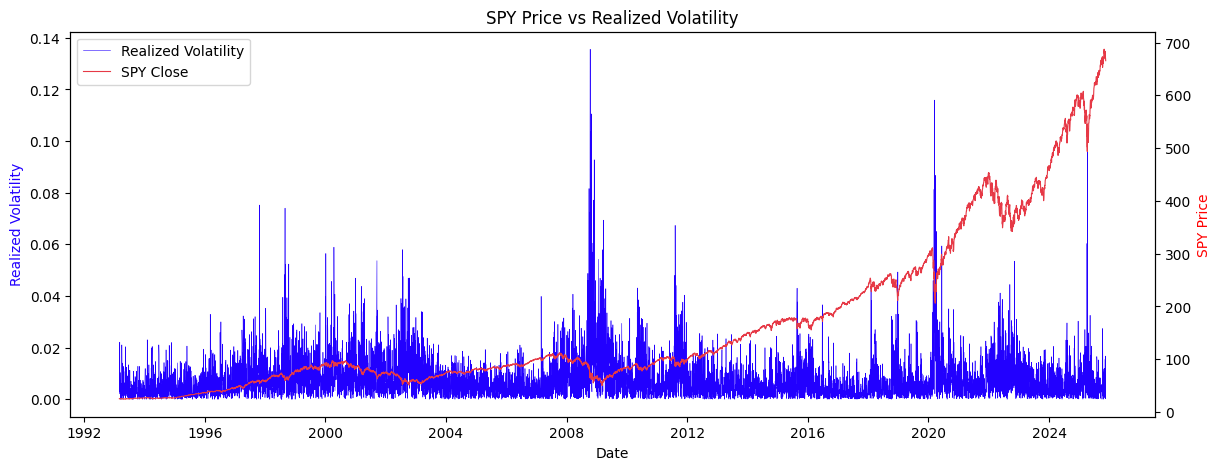

In [143]:
import matplotlib.pyplot as plt

COLORS = {
    "actual": "#2200FF",  # blue
    "pred":   "#E63946",  # red
}

fig, ax1 = plt.subplots(figsize=(14,5))

# Plot realized volatility
line1, = ax1.plot(
    dataset.index, 
    dataset["rvol_1d"], 
    color=COLORS["actual"], 
    label="Realized Volatility",
    linewidth=0.4
)
ax1.set_ylabel("Realized Volatility", color=COLORS["actual"])
ax1.set_xlabel("Date")

# Twin axis for SPY
ax2 = ax1.twinx()
line2, = ax2.plot(
    dataset.index, 
    dataset["Close_SPY"], 
    color=COLORS["pred"], 
    label="SPY Close",
    linewidth=0.8
)
ax2.set_ylabel("SPY Price", color="red")
ax2.set_xlabel("Date")

# --- Combine legends ---
lines = [line1, line2]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc="upper left")

plt.title("SPY Price vs Realized Volatility")
plt.show()

In [144]:
test_index = X_test.index  # dates

results = pd.DataFrame({
    "Actual RV": y_test,
    "RF Prediction": y_test_pred_rf,
    "LR Prediction": y_test_pred_lr,
    "XGB Prediction": y_test_pred_xgb
}, index=test_index)

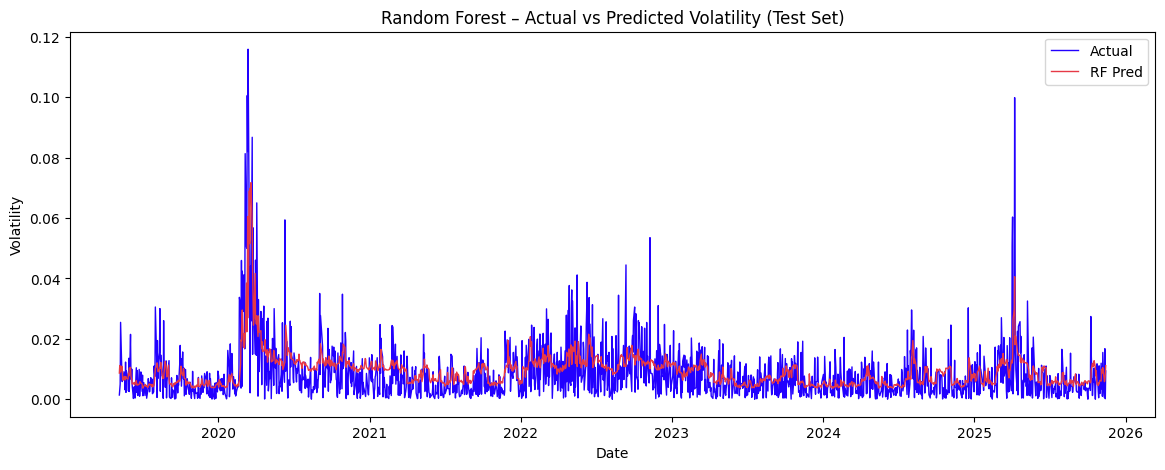

In [145]:
plt.figure(figsize=(14,5))
plt.plot(results.index, results["Actual RV"], color=COLORS["actual"], label="Actual", linewidth=1)
plt.plot(results.index, results["RF Prediction"], color=COLORS["pred"], label="RF Pred", linewidth=1)
plt.title("Random Forest – Actual vs Predicted Volatility (Test Set)")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.legend()
plt.show()

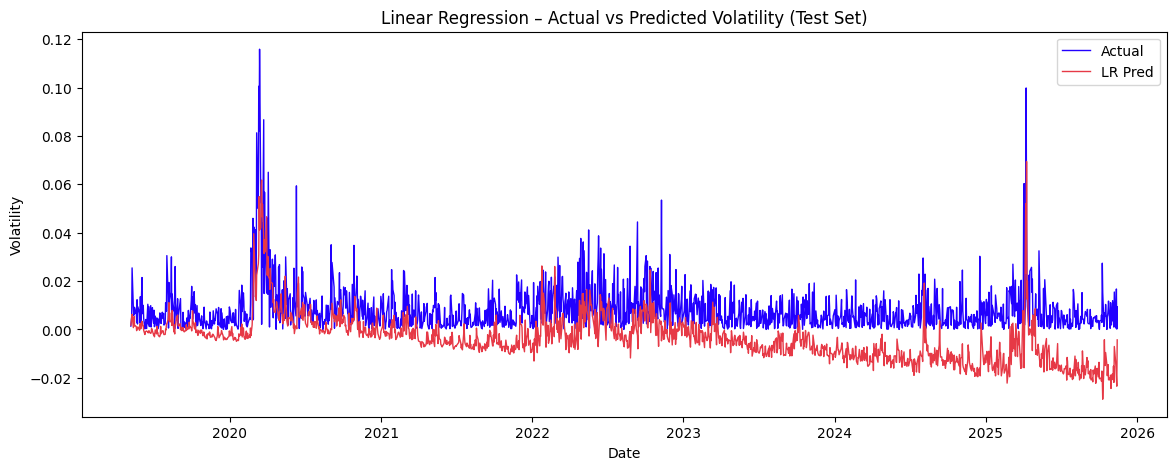

In [146]:
plt.figure(figsize=(14,5))
plt.plot(results.index, results["Actual RV"], color=COLORS["actual"], label="Actual", linewidth=1)
plt.plot(results.index, results["LR Prediction"], color=COLORS["pred"], label="LR Pred", linewidth=1)
plt.title("Linear Regression – Actual vs Predicted Volatility (Test Set)")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.legend()
plt.show()

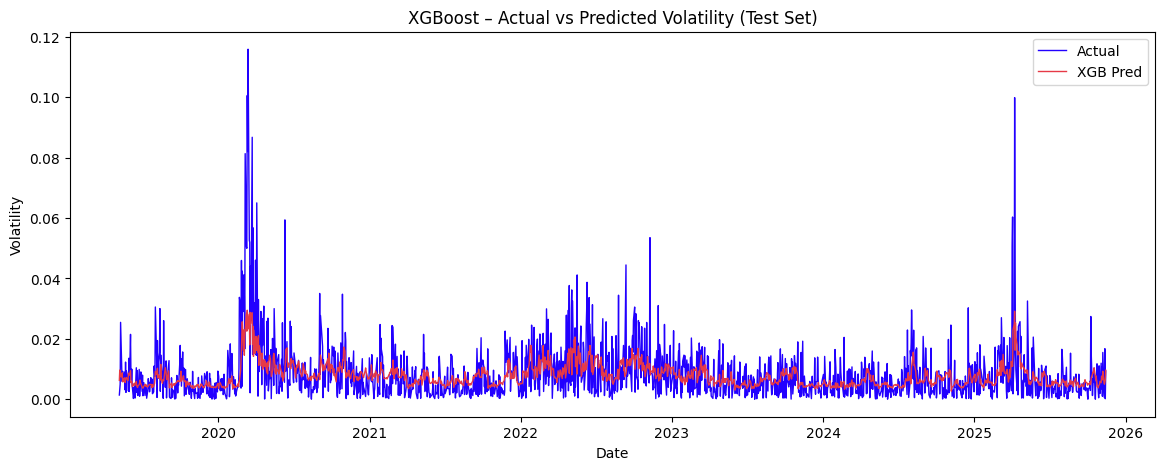

In [147]:
plt.figure(figsize=(14,5))
plt.plot(results.index, results["Actual RV"], color=COLORS["actual"], label="Actual", linewidth=1)
plt.plot(results.index, results["XGB Prediction"], color=COLORS["pred"], label="XGB Pred", linewidth=1)
plt.title("XGBoost – Actual vs Predicted Volatility (Test Set)")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.legend()
plt.show()